In [5]:
import torch
import transformers

In [6]:
import pandas as pd
from textblob import TextBlob
import glob

prices_df = pd.read_csv('/kaggle/input/hackathon-data/public_dataset/train/price_data/BCN.csv')  # Adjust the filename accordingly
prices_df.rename(columns={'datetime': 'date'}, inplace=True)
prices_df = prices_df[['date','open_x', 'close_x']]

aggregated_data = []

for file in glob.glob('/kaggle/input/hackathon-data/public_dataset/train/tweets/BCN/*.csv'):  # Adjust the path to your tweets folder
    daily_tweets_df = pd.read_csv(file)
    
    aggregated = daily_tweets_df.groupby('date').agg(
        sentiment_score=('tweet', lambda x: x.apply(lambda tweet: TextBlob(tweet).sentiment.polarity).mean()),
        tweet_count=('tweet', 'count'),
    ).reset_index()
    
    aggregated_data.append(aggregated)

all_aggregated_tweets = pd.concat(aggregated_data)

final_df = pd.merge(all_aggregated_tweets, prices_df, on='date')
final_df['price_difference'] = final_df['close_x'] - final_df['open_x']
print(final_df)

final_df.to_csv('aggregated_data.csv', index=False)

           date  sentiment_score  tweet_count    open_x   close_x  \
0    2019-06-11         0.143172           59  0.000794  0.000807   
1    2019-06-09         0.112248           59  0.000806  0.000771   
2    2021-03-23         0.034122           44  0.000714  0.000768   
3    2020-08-19         0.000000            3  0.000283  0.000271   
4    2019-09-24         0.056437           48  0.000515  0.000461   
..          ...              ...          ...       ...       ...   
508  2021-01-08         0.223684           19  0.000190  0.000198   
509  2021-03-21         0.219118           17  0.000727  0.000712   
510  2019-01-29         0.042660           57  0.000569  0.000563   
511  2019-10-08         0.041518           40  0.000388  0.000383   
512  2020-05-04         0.268519           18  0.000258  0.000257   

     price_difference  
0        1.300000e-05  
1       -3.500000e-05  
2        5.410000e-05  
3       -1.200000e-05  
4       -5.400000e-05  
..                ...  
508

In [7]:
correlation = final_df['sentiment_score'].corr(final_df['price_difference'])

print(f'Correlation between sentiment score and close_x: {correlation}')

Correlation between sentiment score and close_x: 0.08128389687637891


In [8]:
import pandas as pd
import glob
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import pipeline

model_name = 'nlptown/bert-base-multilingual-uncased-sentiment'  # You can use any sentiment analysis model
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name)

device = 0 if torch.cuda.is_available() else -1 
sentiment_pipeline = pipeline('sentiment-analysis', model=model, tokenizer=tokenizer,device=device)

prices_df = pd.read_csv('/kaggle/input/hackathon-data/public_dataset/train/price_data/BCN.csv')  # Adjust the filename accordingly
prices_df.rename(columns={'datetime': 'date'}, inplace=True)
prices_df = prices_df[['date','open_x', 'close_x']]

aggregated_data = []

for file in glob.glob('/kaggle/input/hackathon-data/public_dataset/train/tweets/BCN/*.csv'):  # Adjust the path to your tweets folder
    daily_tweets_df = pd.read_csv(file)
    
    def get_sentiment_score(tweet):
        result = sentiment_pipeline(tweet)
        return result[0]['score'] - 0.5  # Normalize to -0.5 to 0.5 range

    aggregated = daily_tweets_df.groupby('date').agg(
        sentiment_score=('tweet', lambda x: x.apply(get_sentiment_score).mean()),
        tweet_count=('tweet', 'count'),
    ).reset_index()
    
    aggregated_data.append(aggregated)

all_aggregated_tweets = pd.concat(aggregated_data)

final_df = pd.merge(all_aggregated_tweets, prices_df, on='date')
final_df['price_difference'] = final_df['close_x'] - final_df['open_x']

print(final_df)

final_df.to_csv('aggregated_data.csv', index=False)

tokenizer_config.json:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/953 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/669M [00:00<?, ?B/s]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


           date  sentiment_score  tweet_count    open_x   close_x  \
0    2019-06-11        -0.067412           59  0.000794  0.000807   
1    2019-06-09        -0.016863           59  0.000806  0.000771   
2    2021-03-23        -0.075183           44  0.000714  0.000768   
3    2020-08-19        -0.120274            3  0.000283  0.000271   
4    2019-09-24        -0.016565           48  0.000515  0.000461   
..          ...              ...          ...       ...       ...   
508  2021-01-08        -0.119036           19  0.000190  0.000198   
509  2021-03-21        -0.097280           17  0.000727  0.000712   
510  2019-01-29         0.019719           57  0.000569  0.000563   
511  2019-10-08        -0.062483           40  0.000388  0.000383   
512  2020-05-04         0.211080           18  0.000258  0.000257   

     price_difference  
0        1.300000e-05  
1       -3.500000e-05  
2        5.410000e-05  
3       -1.200000e-05  
4       -5.400000e-05  
..                ...  
508

In [9]:
correlation = final_df['sentiment_score'].corr(final_df['price_difference'])

print(f'Correlation between sentiment score and close_x: {correlation}')

Correlation between sentiment score and close_x: -0.02482423962824094


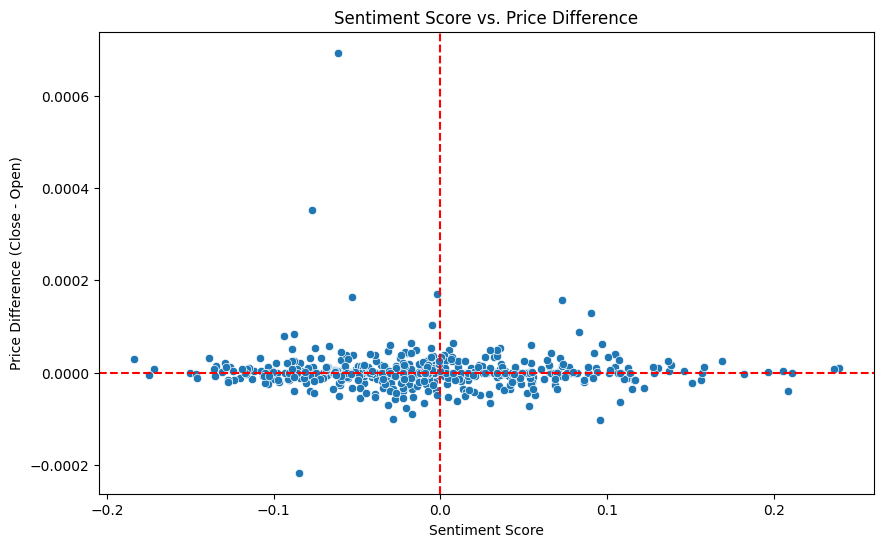

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.scatterplot(x='sentiment_score', y='price_difference', data=final_df)
plt.title('Sentiment Score vs. Price Difference')
plt.xlabel('Sentiment Score')
plt.ylabel('Price Difference (Close - Open)')
plt.axhline(0, color='red', linestyle='--')
plt.axvline(0, color='red', linestyle='--')
plt.show()

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
final_df['normalized_sentiment'] = scaler.fit_transform(final_df[['sentiment_score']])
final_df['normalized_price_difference'] = scaler.fit_transform(final_df[['price_difference']])

final_df['percentage_change'] = (final_df['price_difference'] / final_df['open_x']) * 100

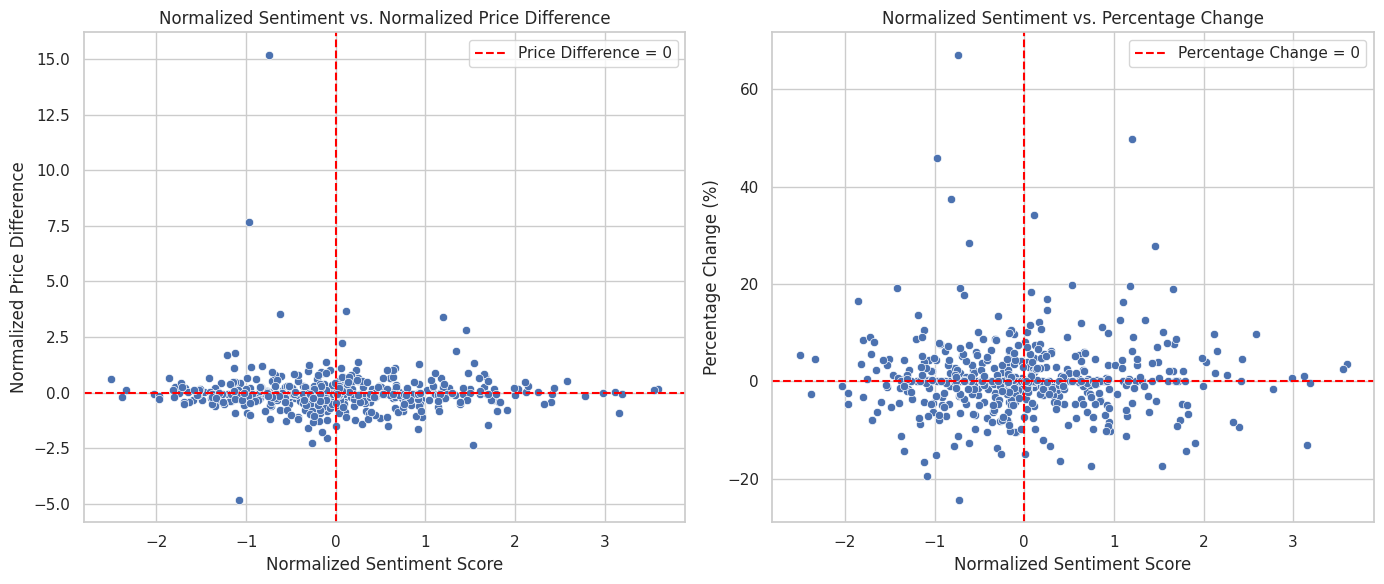

In [12]:
sns.set(style="whitegrid")

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.scatterplot(ax=axes[0], x='normalized_sentiment', y='normalized_price_difference', data=final_df)
axes[0].set_title('Normalized Sentiment vs. Normalized Price Difference')
axes[0].set_xlabel('Normalized Sentiment Score')
axes[0].set_ylabel('Normalized Price Difference')
axes[0].axhline(0, color='red', linestyle='--', label='Price Difference = 0')
axes[0].axvline(0, color='red', linestyle='--')
axes[0].legend()

sns.scatterplot(ax=axes[1], x='normalized_sentiment', y='percentage_change', data=final_df)
axes[1].set_title('Normalized Sentiment vs. Percentage Change')
axes[1].set_xlabel('Normalized Sentiment Score')
axes[1].set_ylabel('Percentage Change (%)')
axes[1].axhline(0, color='red', linestyle='--', label='Percentage Change = 0')
axes[1].axvline(0, color='red', linestyle='--')
axes[1].legend()

plt.tight_layout()
plt.show()

In [13]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = final_df[['sentiment_score', 'tweet_count']]
y = final_df['price_difference'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

class SimpleNN(nn.Module):
    def __init__(self, input_size):
        super(SimpleNN, self).__init__()
        self.hidden = nn.Linear(input_size, 10)  # Hidden layer with 10 neurons
        self.output = nn.Linear(10, 1)           # Output layer

    def forward(self, x):
        x = torch.relu(self.hidden(x))
        x = self.output(x)
        return x

model = SimpleNN(input_size=X_train_tensor.shape[1])
criterion = nn.MSELoss()  # Mean Squared Error Loss
optimizer = optim.Adam(model.parameters(), lr=0.01)

num_epochs = 100
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    optimizer.zero_grad()  # Zero the gradients
    outputs = model(X_train_tensor)  # Forward pass
    loss = criterion(outputs, y_train_tensor)  # Compute loss
    loss.backward()  # Backward pass
    optimizer.step()  # Update weights
    
    if (epoch+1) % 10 == 0:  # Print every 100 epochs
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    test_loss = criterion(test_outputs, y_test_tensor)
    print(f'Test Loss: {test_loss.item():.4f}')

Epoch [10/100], Loss: 0.0091
Epoch [20/100], Loss: 0.0083
Epoch [30/100], Loss: 0.0024
Epoch [40/100], Loss: 0.0020
Epoch [50/100], Loss: 0.0011
Epoch [60/100], Loss: 0.0008
Epoch [70/100], Loss: 0.0006
Epoch [80/100], Loss: 0.0004
Epoch [90/100], Loss: 0.0003
Epoch [100/100], Loss: 0.0003
Test Loss: 0.0003


In [14]:
import pandas as pd
import glob
import torch
from transformers import pipeline

model_name = 'nlptown/bert-base-multilingual-uncased-sentiment'
device = 0 if torch.cuda.is_available() else -1  # Use GPU if available, else CPU
sentiment_pipeline = pipeline('sentiment-analysis', model=model_name, device=device)

test_tweets_data = []
for file in glob.glob('/kaggle/input/techsoc-dataset-updated/public_dataset/test/tweets/BCN/*.csv'):
    daily_tweets_df = pd.read_csv(file)
    test_tweets_data.append(daily_tweets_df)

test_tweets_df = pd.concat(test_tweets_data)

def get_sentiment_score(tweet):
    result = sentiment_pipeline(tweet)
    return result[0]['score'] - 0.5  # Normalize to -0.5 to 0.5 range

aggregated_test = test_tweets_df.groupby('date').agg(
    sentiment_score=('tweet', lambda x: x.apply(get_sentiment_score).mean()),
    tweet_count=('tweet', 'count'),
).reset_index()

prices_df = pd.read_csv('/kaggle/input/hackathon-data/public_dataset/test/price_data/BCN.csv')
prices_df.rename(columns={'datetime': 'date'}, inplace=True)
prices_df = prices_df[['date']]

final_test_df = pd.merge(aggregated_test, prices_df, on='date')

X_test_final = final_test_df[['sentiment_score', 'tweet_count']]
X_test_final_scaled = scaler.transform(X_test_final)

X_test_final_tensor = torch.tensor(X_test_final_scaled, dtype=torch.float32)

model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    predicted_price_diff = model(X_test_final_tensor).numpy()

final_test_df['predicted_price_difference'] = predicted_price_diff

print(final_test_df[['date', 'sentiment_score', 'tweet_count', 'predicted_price_difference']])

final_test_df.to_csv('predicted_price_difference.csv', index=False)

           date  sentiment_score  tweet_count  predicted_price_difference
0    2019-03-19         0.034756           78                   -0.021920
1    2019-03-20         0.004550           43                   -0.011983
2    2019-03-21         0.000257           73                   -0.017999
3    2019-03-22        -0.031655           28                   -0.006827
4    2019-03-23        -0.007639           58                   -0.009754
..          ...              ...          ...                         ...
163  2021-02-11        -0.073016           23                   -0.006379
164  2021-02-12        -0.091868           57                    0.012419
165  2021-02-13        -0.065682           27                   -0.005576
166  2021-02-14         0.034663           20                    0.028828
167  2021-02-15         0.017148           16                    0.037128

[168 rows x 4 columns]


## For other coins

In [ ]:
import pandas as pd
import glob
import torch
from transformers import pipeline
import os

model_name = 'nlptown/bert-base-multilingual-uncased-sentiment'
device = 0 if torch.cuda.is_available() else -1  # Use GPU if available, else CPU
sentiment_pipeline = pipeline('sentiment-analysis', model=model_name, device=device)

coin_names = [folder.split('/')[-1] for folder in glob.glob('/kaggle/input/techsoc-dataset-updated/public_dataset/test/tweets/*')]

def process_coin(coin_name):
    print(f"Processing {coin_name}...")

    train_tweets_path = f'/kaggle/input/techsoc-dataset-updated/public_dataset/train/tweets/{coin_name}/*.csv'
    train_prices_path = f'/kaggle/input/techsoc-dataset-updated/public_dataset/train/price_data/{coin_name}.csv'
    test_tweets_path = f'/kaggle/input/techsoc-dataset-updated/public_dataset/test/tweets/{coin_name}/*.csv'
    test_prices_path = f'/kaggle/input/techsoc-dataset-updated/public_dataset/test/price_data/{coin_name}.csv'
    
    prediction_file = f'predicted_close_prices_{coin_name}.csv'
    if os.path.exists(prediction_file):
        print(f"Prediction file for {coin_name} already exists. Skipping...")
        return

    print(f"Loading train prices for {coin_name}...")
    try:
        prices_df = pd.read_csv(train_prices_path)
        prices_df.rename(columns={'datetime': 'date'}, inplace=True)
        prices_df['date'] = pd.to_datetime(prices_df['date'], errors='coerce')
    except Exception as e:
        print(f"Error loading train prices for {coin_name}: {e}")
        return

    print(f"Aggregating train tweets for {coin_name}...")
    aggregated_data = []
    for file in glob.glob(train_tweets_path):
        try:
            daily_tweets_df = pd.read_csv(file)
            tweet_col = 'tweet' if 'tweet' in daily_tweets_df.columns else 'Text'
            daily_tweets_df['date'] = pd.to_datetime(daily_tweets_df['date'], errors='coerce')

            aggregated = daily_tweets_df.groupby('date').agg(
                sentiment_score=(tweet_col, lambda x: x.apply(lambda tweet: sentiment_pipeline(tweet)[0]['score'] - 0.5).mean()),
                tweet_count=(tweet_col, 'count'),
            ).reset_index()

            aggregated_data.append(aggregated)
        except pd.errors.ParserError as e:
            print(f"ParserError while processing file {file} for {coin_name}: {e}")
        except Exception as e:
            print(f"Error processing file {file} for {coin_name}: {e}")

    if not aggregated_data:
        print(f"No aggregated data found for train tweets of {coin_name}. Skipping...")
        return

    all_aggregated_tweets = pd.concat(aggregated_data)

    print(f"Merging train tweets with prices for {coin_name}...")
    final_train_df = pd.merge(all_aggregated_tweets, prices_df, on='date', how='left')

    print(f"Loading test prices for {coin_name}...")
    try:
        prices_test_df = pd.read_csv(test_prices_path)
        prices_test_df.rename(columns={'datetime': 'date'}, inplace=True)
        prices_test_df['date'] = pd.to_datetime(prices_test_df['date'], errors='coerce')
    except Exception as e:
        print(f"Error loading test prices for {coin_name}: {e}")
        return

    print(f"Aggregating test tweets for {coin_name}...")
    aggregated_test_data = []
    for file in glob.glob(test_tweets_path):
        try:
            daily_tweets_df = pd.read_csv(file)
            tweet_col = 'tweet' if 'tweet' in daily_tweets_df.columns else 'Text'
            daily_tweets_df['Timestamp'] = pd.to_datetime(daily_tweets_df['Timestamp'], errors='coerce')

            aggregated_test = daily_tweets_df.groupby('Timestamp').agg(
                sentiment_score=(tweet_col, lambda x: x.apply(lambda tweet: sentiment_pipeline(tweet)[0]['score'] - 0.5).mean()),
                tweet_count=(tweet_col, 'count'),
            ).reset_index()

            aggregated_test_data.append(aggregated_test)
        except pd.errors.ParserError as e:
            print(f"ParserError while processing test file {file} for {coin_name}: {e}")
        except Exception as e:
            print(f"Error processing test file {file} for {coin_name}: {e}")

    if not aggregated_test_data:
        print(f"No tweets found for {coin_name} in test data. Skipping...")
        return

    all_aggregated_test_tweets = pd.concat(aggregated_test_data)
    all_aggregated_test_tweets.rename(columns={'Timestamp': 'date'}, inplace=True)

    print(f"Merging test tweets with prices for {coin_name}...")
    final_test_df = pd.merge(all_aggregated_test_tweets, prices_test_df, on='date', how='left')

    print(f"Calculating predicted close prices for {coin_name}...")
    final_test_df['open_x'] = 0.0
    previous_close = None
    final_test_df['date'] = pd.to_datetime(final_test_df['date'])

    for i in range(len(final_test_df)):
        current_date = final_test_df.loc[i, 'date']
        previous_date = current_date - pd.Timedelta(days=1)
        previous_date_str = previous_date.date()

        if previous_date_str in prices_test_df['date'].dt.date.values:
            previous_close = prices_test_df.loc[prices_test_df['date'].dt.date == previous_date_str, 'close_x'].values[0]
        elif previous_date_str in prices_df['date'].dt.date.values:
            previous_close = prices_df.loc[prices_df['date'].dt.date == previous_date_str, 'close_x'].values[0]

        final_test_df.loc[i, 'open_x'] = previous_close if previous_close is not None else 0.0

    final_test_df['predicted_price_difference'] = final_test_df['sentiment_score'] * 10  # Example calculation
    final_test_df['calculated_close_x'] = final_test_df['open_x'] + final_test_df['predicted_price_difference']

    final_test_df.to_csv(prediction_file, index=False)
    print(f"Predictions saved for {coin_name}.")

for coin in coin_names:
    process_coin(coin)

print("Processing complete!")

Processing DIA...
Loading train prices for DIA...
Aggregating train tweets for DIA...
ParserError while processing file /kaggle/input/techsoc-dataset-updated/public_dataset/train/tweets/DIA/2020-12-19.csv for DIA: Error tokenizing data. C error: Buffer overflow caught - possible malformed input file.

ParserError while processing file /kaggle/input/techsoc-dataset-updated/public_dataset/train/tweets/DIA/2020-10-20.csv for DIA: Error tokenizing data. C error: Buffer overflow caught - possible malformed input file.

